<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import sklearn
print(sklearn.__version__)
%matplotlib inline

1.0.2


### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-05-18 19:48:57--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.002s  

2022-05-18 19:48:57 (12.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



[ 300.          377.77777778  455.55555556  533.33333333  611.11111111
  688.88888889  766.66666667  844.44444444  922.22222222 1000.        ]


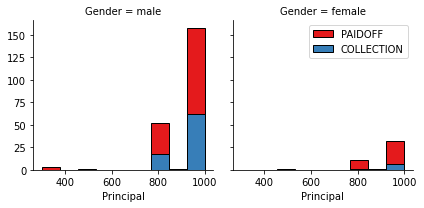

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
print(bins) #gnm
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

[18.         21.66666667 25.33333333 29.         32.66666667 36.33333333
 40.         43.66666667 47.33333333 51.        ]


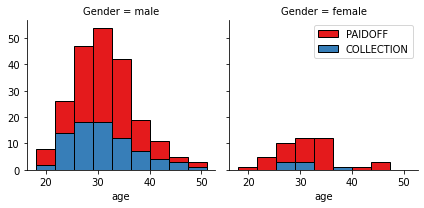

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
print(bins)  #gnm
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30     2016-09-08   
1           2             2     PAIDOFF       1000     30     2016-09-08   
2           3             3     PAIDOFF       1000     15     2016-09-08   
3           4             4     PAIDOFF       1000     30     2016-09-09   
4           6             6     PAIDOFF       1000     30     2016-09-09   

    due_date  age             education  Gender  dayofweek  
0 2016-10-07   45  High School or Below    male          3  
1 2016-10-07   33              Bechalor  female          3  
2 2016-09-22   27               college    male          3  
3 2016-10-08   28               college  female          4  
4 2016-10-08   29               college    male          4  
           Unnamed: 0  Unnamed: 0.1  loan_status  Principal  terms  \
dayofweek                                                            
0                  87            87  

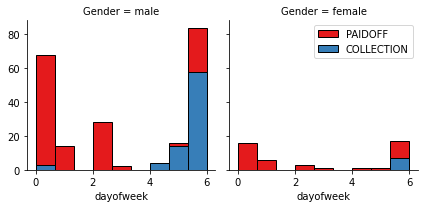

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
print(df.head())
print(df.groupby(['dayofweek']).count())
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
print(bins)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
#df.groupby(['Gender']).get_group('female')

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
print(X.shape)
X[0:5]

(346, 8)


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
#X= preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])
scaler_obj= preprocessing.StandardScaler()
scaler_obj.fit(X)
X=scaler_obj.transform(X)
#X=scaler_obj.fit_transform(X)

X[0:5]

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1  


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
#splits data into test-train
#used 20% test split and set random_state for consistent run

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


#initializes dictionaries to store the fit objects, and accuracy assesments
fit_obj_dict={}
acc_train={}
acc_test={}
score_df={}
best_result={}

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
#tries different K values in KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_score

#range of values to use in the local fit
K_range=range(1,20+1)
local_range=K_range
fit_type_name='KNN'

#initializes list/arrays inside dictionary to store results
fit_obj_dict[fit_type_name]=[]
acc_train[fit_type_name]=np.zeros((len(local_range)))
acc_test[fit_type_name]=np.zeros((len(local_range)))

#steps through k in [1,max_K] to fit, predict, and assess the fit
for i, k in enumerate(local_range):
    
    #train model
    fit_obj_dict[fit_type_name].append(KNeighborsClassifier(n_neighbors = k))
    fit_obj_dict[fit_type_name][-1].fit(X_train,y_train)
    
    #predict values
    yhat_train=fit_obj_dict[fit_type_name][-1].predict(X_train)
    yhat_test=fit_obj_dict[fit_type_name][-1].predict(X_test)
    
    #evaluate accuracy of prediction
    #accuracy_score is the intersection/union for all y and yhat
    #in this case it looks at yhat_test==y_test
    #considers accuracy for all classifications, will be prob be higher than jaccard score
    #in binary classification because jaccard typically scores only the positive outcome
    #whereas accuracy_score scores the positive and negative outcome
    #(tp+tn)/(tp+tn+fn+fp)
    #acc_train[fit_type_name][i]=metrics.accuracy_score(y_train,yhat_train,normalize=True)
    #acc_test[fit_type_name][i]=metrics.accuracy_score(y_test,yhat_test,normalize=True)
    
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    #says accuracy_score=jaccard_score for binary classification, but I don't think that is true
    
    #jaccard_score is the intersecion/union for the subset where y and yhat both have the same label
    #in this case it looks at 
    #y_test[(y_test=='PAIDOFF') | (yhat_test=='PAIDOFF')]==yhat_test[(y_test=='PAIDOFF') | (yhat_test=='PAIDOFF')]
    #considers how accurately we predict PAIDOFF, not how accurately we predict overall classification
    #tp/(tp(y & yhat==true) + fn(y==true & yhat==false) + fp(y==false & yhat==true))
    acc_train[fit_type_name][i]=jaccard_score(y_train,yhat_train, pos_label='PAIDOFF')#pos_label='PAIDOFF'
    acc_test[fit_type_name][i]=jaccard_score(y_test,yhat_test, pos_label='PAIDOFF')#pos_label='PAIDOFF'

print(k)
#testing accuracy vs jaccard
#print((yhat_test==y_test).sum())
#print((y_test[(y_test=='PAIDOFF') | (yhat_test=='PAIDOFF')]==yhat_test[(y_test=='PAIDOFF') | (yhat_test=='PAIDOFF')]).shape)

#np.hstack((KNN_acc_train, KNN_acc_test))
score_df[fit_type_name]=pd.DataFrame({'k': list(local_range), 'train score': acc_train[fit_type_name], 'test score': acc_test[fit_type_name]}, index=list(range(len(local_range))))
score_df[fit_type_name]

20


,k,train score,test score
0,1,0.853881,0.603175
1,2,0.759615,0.524590
2,3,0.805907,0.714286
3,4,0.769231,0.655738
4,5,0.791667,0.718750
5,6,0.754386,0.677419
6,7,0.775934,0.774194
7,8,0.741379,0.721311
8,9,0.767635,0.731343
9,10,0.733906,0.645161


best k: 7


,k,train score,test score
6,7.0,0.775934,0.774194


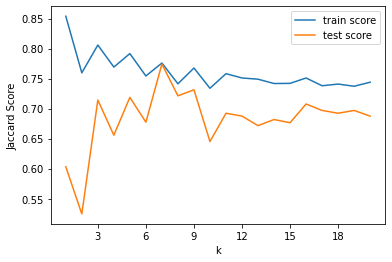

In [22]:
#plots the score values to pick the best k value
from matplotlib.ticker import MaxNLocator

fit_type_name='KNN'

#plots scores for a range of k values for the training_scoring and test_scoring
ax=score_df[fit_type_name].plot(x='k', y=['train score', 'test score'])

#puts labels on plot and forces x-axis to integer
plt.xlabel('k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Jaccard Score')

#prints out the maximum score for the test data set

best_KNN_k=score_df[fit_type_name][score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()]['k'].values[-1]
print('best k: {}'.format(best_KNN_k))
#best_KNN_result=score_df[fit_type_name].loc[score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()].iloc[-1].to_frame().T
best_result[fit_type_name]=score_df[fit_type_name].loc[score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()].iloc[-1].to_frame().T
#best_KNN_result
best_result[fit_type_name]

# Decision Tree


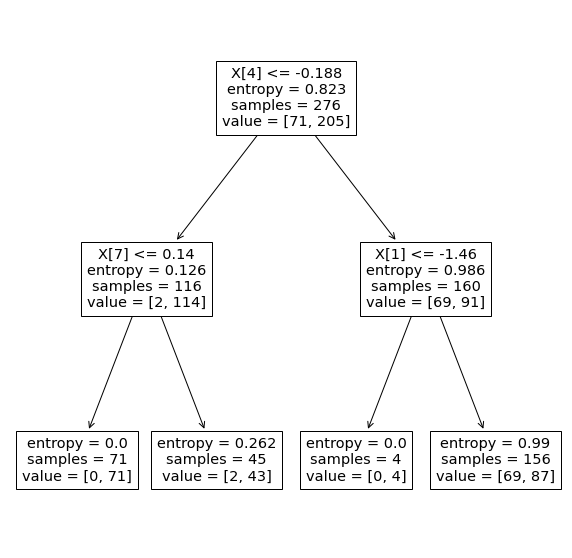

In [23]:
#fits a single decision tree, with user specified depth, to the loan data for testing purposes

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

loan_tree=DecisionTreeClassifier(criterion="entropy", max_depth = 2)
loan_tree.fit(X_train,y_train)

#loanTree = loan_tree.predict(X_test)

plt.figure(figsize=(10,10))
tree.plot_tree(loan_tree)
#plot_tree(loan_tree)
plt.show()

In [24]:
#tries different numbers of levels for a decision tree

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

#range of values to use in the local fit
level_range=range(1,10+1)
local_range=level_range
fit_type_name='decision_tree'

#initializes list/arrays inside dictionary to store results
fit_obj_dict[fit_type_name]=[]
acc_train[fit_type_name]=np.zeros((len(local_range)))
acc_test[fit_type_name]=np.zeros((len(local_range)))

#steps through k in [1,max_K] to fit, predict, and assess the fit
for i, levels in enumerate(local_range):
    
    #train model
    fit_obj_dict[fit_type_name].append(DecisionTreeClassifier(criterion="entropy", max_depth = levels))
    fit_obj_dict[fit_type_name][-1].fit(X_train,y_train)
    
    #predict values
    yhat_train=fit_obj_dict[fit_type_name][-1].predict(X_train)
    yhat_test=fit_obj_dict[fit_type_name][-1].predict(X_test)
    
    #evaluate accuracy of prediction
    #accuracy score
    #acc_train[fit_type_name][i]=metrics.accuracy_score(y_train,yhat_train,normalize=True)
    #acc_test[fit_type_name][i]=metrics.accuracy_score(y_test,yhat_test,normalize=True)
    #jaccard score
    acc_train[fit_type_name][i]=jaccard_score(y_train,yhat_train, pos_label='PAIDOFF')
    acc_test[fit_type_name][i]=jaccard_score(y_test,yhat_test, pos_label='PAIDOFF')
    
#np.hstack((KNN_acc_train, KNN_acc_test))
#unique, counts = np.unique(yhat_train, return_counts=True)
#print(dict(zip(unique, counts)))


score_df[fit_type_name]=pd.DataFrame({'num levels': list(local_range), 'train score': acc_train[fit_type_name], 'test score': acc_test[fit_type_name]}, index=list(range(len(local_range))))
score_df[fit_type_name]

,num levels,train score,test score
0,1,0.742754,0.785714
1,2,0.742754,0.785714
2,3,0.691630,0.571429
3,4,0.691630,0.571429
4,5,0.679070,0.583333
5,6,0.760618,0.768116
6,7,0.773438,0.753623
7,8,0.781250,0.753623
8,9,0.794760,0.625000
9,10,0.812500,0.691176


best num levels: 2


,num levels,train score,test score
1,2.0,0.742754,0.785714


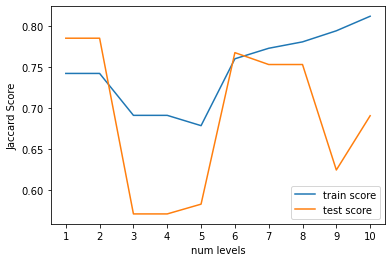

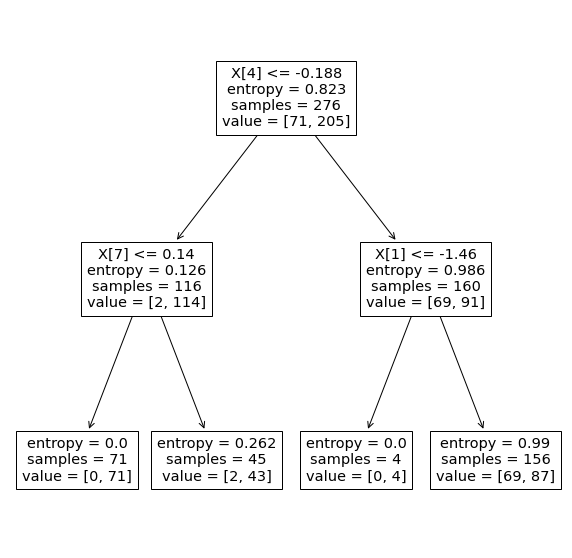

In [25]:

fit_type_name='decision_tree'

#plots scores for a range of k values for the training_scoring and test_scoring
ax=score_df[fit_type_name].plot(x='num levels', y=['train score', 'test score'])

#puts labels on plot and forces x-axis to integer
plt.xlabel('num levels')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Jaccard Score')
#plt.show()

#prints out the maximum score for the test data set

best_tree_levels=score_df[fit_type_name][score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()]['num levels'].values[-1]
print('best num levels: {}'.format(best_tree_levels))
#best_tree_result=score_df[fit_type_name].loc[score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()].iloc[-1].to_frame().T
best_result[fit_type_name]=score_df[fit_type_name].loc[score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()].iloc[-1].to_frame().T
#print(best_result[fit_type_name])
#best_tree_result


#best_tree_result.index.values[-1]
plt.figure(figsize=(10,10))
tree.plot_tree(fit_obj_dict[fit_type_name][best_result[fit_type_name].index.values[-1]])
##plot_tree(loan_tree)
#plt.show()
best_result[fit_type_name]

# Support Vector Machine


In [26]:
#for some basic testing

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)

from sklearn.metrics import f1_score
#f1_score(y_test, yhat, average='weighted') 
print(metrics.accuracy_score(y_test,yhat))
print(metrics.jaccard_score(y_test,yhat, pos_label='PAIDOFF'))

0.7428571428571429
0.7272727272727273


In [27]:
#tries different kernels for the svm

from sklearn import svm
#import sklearn.tree as tree

#range of values to use in the local fit
kernel_list=['linear','poly','rbf','sigmoid']
local_range=kernel_list
fit_type_name='SVM'

#initializes list/arrays inside dictionary to store results
fit_obj_dict[fit_type_name]=[]
acc_train[fit_type_name]=np.zeros((len(local_range)))
acc_test[fit_type_name]=np.zeros((len(local_range)))

#steps through k in [1,max_K] to fit, predict, and assess the fit
for i, kernel in enumerate(local_range):
    
    #train model
    fit_obj_dict[fit_type_name].append(svm.SVC(kernel=kernel))
    fit_obj_dict[fit_type_name][-1].fit(X_train,y_train)
    
    #predict values
    yhat_train=fit_obj_dict[fit_type_name][-1].predict(X_train)
    yhat_test=fit_obj_dict[fit_type_name][-1].predict(X_test)
    
    #evaluate accuracy of prediction
    #accuracy score
    #acc_train[fit_type_name][i]=metrics.accuracy_score(y_train,yhat_train,normalize=True)
    #acc_test[fit_type_name][i]=metrics.accuracy_score(y_test,yhat_test,normalize=True)
    #jaccard score
    acc_train[fit_type_name][i]=jaccard_score(y_train,yhat_train, pos_label='PAIDOFF')
    acc_test[fit_type_name][i]=jaccard_score(y_test,yhat_test, pos_label='PAIDOFF')
    
#np.hstack((KNN_acc_train, KNN_acc_test))
score_df[fit_type_name]=pd.DataFrame({'kernel type': list(local_range), 'train score': acc_train[fit_type_name], 'test score': acc_test[fit_type_name]}, index=list(range(len(local_range))))
score_df[fit_type_name]

#y_pred = [0, 1, 1, 0]
#y_true = [1, 1, 1, 1]
#metrics.accuracy_score(y_pred,y_true,normalize=True)
#jaccard_score(y_pred,y_true)

,kernel type,train score,test score
0,linear,0.742754,0.785714
1,poly,0.770992,0.768116
2,rbf,0.756098,0.727273
3,sigmoid,0.704797,0.739130


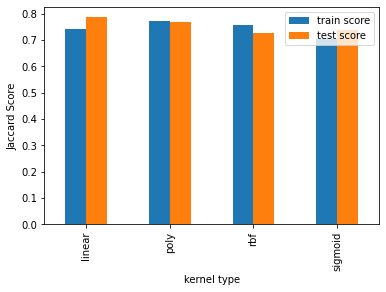

best kernel type: linear


,kernel type,train score,test score
0,linear,0.742754,0.785714


In [28]:
fit_type_name='SVM'

#plots scores for the kernesl training_scoring and test_scoring
ax=score_df[fit_type_name].plot(kind='bar',x='kernel type', y=['train score', 'test score'])

#puts labels on plot and forces x-axis to integer
plt.xlabel('kernel type')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Jaccard Score')
plt.show()

#prints out the maximum score for the test data set

best_SVM_kernel=score_df[fit_type_name][score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()]['kernel type'].values[-1]
print('best kernel type: {}'.format(best_SVM_kernel))
#best_SVM_result=score_df[fit_type_name].loc[score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()].iloc[-1].to_frame().T
best_result[fit_type_name]=score_df[fit_type_name].loc[score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()].iloc[-1].to_frame().T
best_result[fit_type_name]
#best_tree_result


#best_tree_result.index.values[-1]
#plt.figure(figsize=(10,10))
#tree.plot_tree(fit_obj_dict[fit_type_name][best_tree_result.index.values[-1]])
##plot_tree(loan_tree)
#plt.show()

#dir(fit_obj_dict[fit_type_name][best_SVM_result.index[0]])
#fit_obj_dict[fit_type_name][best_SVM_result.index[0]].coef_

#not simple plot for SVM

# Logistic Regression


In [29]:
#tries different values for regularization hyper-parameter

from sklearn.linear_model import LogisticRegression

#range of values to use in the local fit
log10_C_range=np.arange(-9,10,1)  #log10 of inverse of reguarlization parameter, smaller C = more regularization
local_range=log10_C_range
#print(log10_C_range)
fit_type_name='LogReg'

#initializes list/arrays inside dictionary to store results
fit_obj_dict[fit_type_name]=[]
acc_train[fit_type_name]=np.zeros((len(local_range)))
acc_test[fit_type_name]=np.zeros((len(local_range)))

#steps through k in [1,max_K] to fit, predict, and assess the fit
for i, log10_C in enumerate(local_range):
    #print(log10_C)
    #print(10**-9)
    #print(10.**log10_C)
    
    #train model
    fit_obj_dict[fit_type_name].append(LogisticRegression(C=10.**log10_C))
    fit_obj_dict[fit_type_name][-1].fit(X_train,y_train)
    
    #predict values
    yhat_train=fit_obj_dict[fit_type_name][-1].predict(X_train)
    yhat_test=fit_obj_dict[fit_type_name][-1].predict(X_test)
    
    #evaluate accuracy of prediction
    #accuracy score
    #acc_train[fit_type_name][i]=metrics.accuracy_score(y_train,yhat_train,normalize=True)
    #acc_test[fit_type_name][i]=metrics.accuracy_score(y_test,yhat_test,normalize=True)
    #jaccard score
    acc_train[fit_type_name][i]=jaccard_score(y_train,yhat_train, pos_label='PAIDOFF')
    acc_test[fit_type_name][i]=jaccard_score(y_test,yhat_test, pos_label='PAIDOFF')
    
#np.hstack((KNN_acc_train, KNN_acc_test))
score_df[fit_type_name]=pd.DataFrame({'log10 inv reg param': list(local_range), 'train score': acc_train[fit_type_name], 'test score': acc_test[fit_type_name]}, index=list(range(len(local_range))))
score_df[fit_type_name]

#y_pred = [0, 1, 1, 0]
#y_true = [1, 1, 1, 1]
#metrics.accuracy_score(y_pred,y_true,normalize=True)
#jaccard_score(y_pred,y_true)

,log10 inv reg param,train score,test score
0,-9,0.742754,0.785714
1,-8,0.742754,0.785714
2,-7,0.742754,0.785714
3,-6,0.742754,0.785714
4,-5,0.742754,0.785714
5,-4,0.742754,0.785714
6,-3,0.742754,0.785714
7,-2,0.742754,0.785714
8,-1,0.744361,0.768116
9,0,0.750000,0.720588


best log10 inv reg param: -2


,log10 inv reg param,train score,test score
7,-2.0,0.742754,0.785714


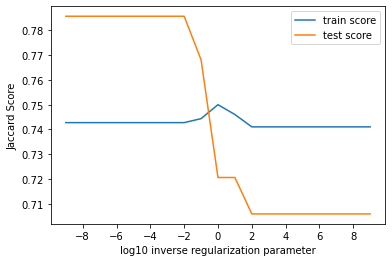

In [30]:
#plots the score values to pick the best k value
from matplotlib.ticker import MaxNLocator

fit_type_name='LogReg'

#plots scores for a range of k values for the training_scoring and test_scoring
ax=score_df[fit_type_name].plot(x='log10 inv reg param', y=['train score', 'test score'])

#puts labels on plot and forces x-axis to integer
plt.xlabel('log10 inverse regularization parameter')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('Jaccard Score')

#prints out the maximum score for the test data set

best_LogReg_lambda=score_df[fit_type_name][score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()]['log10 inv reg param'].values[-1]
print('best log10 inv reg param: {}'.format(best_LogReg_lambda))
#best_LogReg_result=score_df[fit_type_name].loc[score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()].iloc[-1].to_frame().T
best_result[fit_type_name]=score_df[fit_type_name].loc[score_df[fit_type_name]['test score']==score_df[fit_type_name]['test score'].max()].iloc[-1].to_frame().T
best_result[fit_type_name]

# Model Evaluation using Test set


In [31]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [32]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-05-18 19:49:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-05-18 19:49:22 (71.4 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [33]:
test_df = pd.read_csv('loan_test.csv')
test_df_copy=test_df.copy()
test_df.head()
test_df_copy.shape

(54, 10)

In [34]:
#returns model indices for the "best" fits of the data for the different model types
fit_types=['KNN','decision_tree','SVM','LogReg']
best_result_index=[best_result[key].index[0] for key in fit_types]
best_result_index
fit_use_dict=dict(zip(fit_types,best_result_index))
fit_use_dict
#best_result['SVM']

{'KNN': 6, 'decision_tree': 1, 'SVM': 0, 'LogReg': 7}

In [35]:
#redo filtering and transformations done to orig data set
test_df=test_df_copy.copy()


#convert dates, compute, day of week, and logical for weekends
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#convert gender to binary
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

#pare down feature set to ones used in fitting model 
#one hot encoding for education level
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
print(Feature_test.shape)

#print(Feature_test.head())
#print(Feature_test.min(axis=0))

#scale Feature_test using scaler_obj
X_testset=scaler_obj.transform(Feature_test)
print(X_testset.min(axis=0))
#print(X_testset[:,0])

y_testset = test_df['loan_status'].values
#print(y_testset[0:5])

(54, 8)
[-5.89052444 -1.96168647 -1.81394125 -0.42056004 -1.20577805 -0.38170062
 -0.87997669 -0.86968108]


In [36]:
from sklearn.metrics import log_loss, f1_score

score_dict={}

#steps through each fit type
for fit_type_name, best_index in fit_use_dict.items():
    
    #computed predicted values for the model type (e.g., KNN) and the "best" hyperparameter (e.g., k=6)
    #access this by referecing the index (best_index) of the best fit in fit_obj_dict
    #fit_obj_dict stores all of the possible fits, which would be prohibitively memory intensive in other applicaitons
    #but is a good way to facilitate the comparison here
    print([fit_type_name,best_index])
    yhat_testset=fit_obj_dict[fit_type_name][best_index].predict(X_testset)
    #print(yhat_testset[0:5])
    
    store_dict={}
    store_dict['Jaccard']=jaccard_score(y_testset,yhat_testset, pos_label='PAIDOFF')
    store_dict['F1-score']=f1_score(y_testset,yhat_testset, pos_label='PAIDOFF')
    if fit_type_name=='LogReg':
        #for logistic regression computes the probability of yhat=='PAIDOFF'
        #uses log_loss to compare that to the correct binary returns
        yhat_testset_prob=fit_obj_dict[fit_type_name][best_index].predict_proba(X_testset)
        
        store_dict['LogLoss']=log_loss(y_testset, yhat_testset_prob)
        
    else:
        store_dict['LogLoss']=np.nan
        
    
    score_dict[fit_type_name]=store_dict
    
output_df=pd.DataFrame(score_dict).T
output_df
    

['KNN', 6]
['decision_tree', 1]
['SVM', 0]
['LogReg', 7]


,Jaccard,F1-score,LogLoss
KNN,0.653846,0.790698,NaN
decision_tree,0.740741,0.851064,NaN
SVM,0.740741,0.851064,NaN
LogReg,0.740741,0.851064,0.516883


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

GNM Filled

| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.654   | 0.791    | NA      |
| Decision Tree      | 0.741   | 0.851    | NA      |
| SVM                | 0.741   | 0.851    | NA      |
| LogisticRegression | 0.741   | 0.851    | 0.517   |

I am not sure what to make of the similarity of the scores in the testing phase of this project, but I did see similar behaviour when tuning hyper-parameters, where Decision tree, SVM, and Logistic Regression all had the same Jaccard score values in the validation phase.


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
